In [2]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
# Import statements:

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [4]:
# Local data paths:

GTFS_DATA_PATH = "mmt_gtfs/"
import os; os.listdir(GTFS_DATA_PATH) # Peak whats in the directory 

['fare_attributes.txt',
 'transfers.txt',
 'agency.txt',
 'Metro_Transit_Bus_Routes.cpg',
 'Metro_Transit_Bus_Routes.shp',
 'Metro_Transit_Bus_Routes.shx',
 'fare_rules.txt',
 'calendar_dates.txt',
 'stop_times.txt',
 'Metro_Transit_Bus_Routes.dbf',
 'shapes.txt',
 'trips.txt',
 'feed_info.txt',
 'Metro_Transit_Bus_Routes.prj',
 'stops.txt',
 'linked_datasets.txt',
 'Metro_Transit_Ridership_by_Route_Weekday.csv',
 'stop_features.txt',
 'calendar.txt',
 'routes.txt',
 'translations.txt']

In [5]:
def getPandasDFCSV(path, file, sep=','):  
    """ Keyword Arg sep: deliminator used in txt file (default = ',')"""
    pandasDF = pd.read_csv(path +  file, sep=sep)
    return pandasDF

In [6]:
stop_times_df = getPandasDFCSV(GTFS_DATA_PATH, 'stop_times.txt')
#stop_times_df.info()
#stop_times_df.head(3)
trips_df = getPandasDFCSV(GTFS_DATA_PATH, 'trips.txt')
#trips_df.info()
#trips_df.head(3)
stops_df = getPandasDFCSV(GTFS_DATA_PATH, 'stops.txt')
#stops_df.info()
#stops_df.head(3)
trips_df = getPandasDFCSV(GTFS_DATA_PATH, 'trips.txt')
#trips_df.info()
#trips_df.head(3)

In [7]:
# list of possible trips:

service_id_list = []

for i in trips_df['service_id']:
    if i not in service_id_list:
        service_id_list.append(i)
print(service_id_list)

['92_WKD', '92_SAT', '92_SUN', '92_HOL', '92_MWK', '92_WKD:R', '92_SAT:R', '92_SUN:R', '92_HOL:R', '92_SAT:L', '92_SUN:L', '92_WKD:L#6', '92_WKD:L=6', '92_WKD:S', '92_SAT:S', '92_SUN:S', '92_WKD:S#6', '92_WKD:S=6']


In [8]:
# list of possible routes:

route_short_name_list = []

for i in trips_df['route_short_name']:
    if i not in route_short_name_list:
        route_short_name_list.append(i)

route_short_name_list.sort()
print(route_short_name_list)

[2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55, 59, 63, 67, 68, 70, 72, 73, 75, 78, 80, 81, 82, 84]


In [10]:
trips_df_weekday_peak = trips_df[trips_df['service_id'] == '92_WKD']
trips_df_weekday_peak_R = trips_df[trips_df['service_id'] == '92_WKD:R']
trips_df_weekday_peak_s = trips_df[trips_df['service_id'] == '92_WKD:L#6']
trips_df_weekday_peak_s3 = trips_df[trips_df['service_id'] == '92_WKD:L=6']
trips_df_weekday_peak_s1 = trips_df[trips_df['service_id'] == '92_WKD:S']
trips_df_weekday_peak_s2 = trips_df[trips_df['service_id'] == '92_WKD:S#6']
trips_df_weekday_peak_s4 = trips_df[trips_df['service_id'] == '92_WKD:S=6']

dfs_wk = [trips_df_weekday_peak, trips_df_weekday_peak_R, trips_df_weekday_peak_s, 
          trips_df_weekday_peak_s1, trips_df_weekday_peak_s2, trips_df_weekday_peak_s4]

trips_df_weekday = pd.concat(dfs_wk)
#trips_df_weekday.head()

In [11]:
routes_wk_list = []
for route in trips_df_weekday['route_short_name']:
    if route not in routes_wk_list:
        routes_wk_list.append(route)

routes_wk_list.sort()
print(routes_wk_list)

[2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 26, 27, 30, 31, 32, 33, 36, 39, 40, 44, 48, 49, 50, 51, 52, 55, 67, 70, 72, 73, 75, 80, 81, 82, 84]


In [12]:
print("weekend and holiday routes:")
for route in route_short_name_list:
    if route not in routes_wk_list:
        print(route)

weekend and holiday routes:
59
63
68
78


In [13]:
# make a dictionary of routes with trip ID's for weekday service:

tripIDList_forRoutes_weekday92 = dict()

for i in routes_wk_list:
    trip_list = []
    for j in trips_df_weekday[trips_df_weekday['route_short_name'] == i].iterrows():
        trip_list.append(j[1]['trip_id'])
    tripIDList_forRoutes_weekday92[i] = trip_list

#tripIDList_forRoutes_weekday92[23]

In [14]:
for route in tripIDList_forRoutes_weekday92:
    
    for trip in tripIDList_forRoutes_weekday92[route]:
        trip_stop_time_df = stop_times_df[stop_times_df['trip_id'] == trip]

In [15]:
def get_stop_distances(trip):
    """ getting the stop spacing for a given trip. Stop spacing is defined as the distance travelled by bus between two cosecutive stops. 
    Should mirror natural walking terrain better than distance between two globe points.
    
    return: numpy array - contains # of stops - 1 elements that are the distances between stops driven by the bus
    """
    stop_dist_array = []
    trip_stop_time_df = stop_times_df[stop_times_df['trip_id'] == trip]
    distance_travelled = np.array(trip_stop_time_df['shape_dist_traveled'])
    for i in range(len(distance_travelled)-1):
        stop_spacing = distance_travelled[i+1] - distance_travelled[i]
        stop_dist_array.append(stop_spacing)
        
    return stop_dist_array

print(get_stop_distances(9999999))

[0.1754, 0.23489999999999997, 0.09029999999999999, 0.25650000000000006, 0.24869999999999992, 0.09620000000000006, 0.20589999999999997, 0.21829999999999994, 0.1684000000000001, 0.25239999999999996, 0.3065, 0.1383000000000001, 0.11730000000000018, 0.20689999999999964, 0.15210000000000035, 0.1325999999999996, 0.15980000000000016, 0.20020000000000016, 0.3004000000000002]


In [16]:
all_trip_distances_forRoutes_weekday92 = dict()

for route in tripIDList_forRoutes_weekday92:
    #print(route)
    all_trip_distances = []
    for trip in tripIDList_forRoutes_weekday92[route]:
        #print(trip)
        trip_distances = get_stop_distances(trip)
        all_trip_distances.append(trip_distances)
    all_trip_distances_forRoutes_weekday92[route] = all_trip_distances
    
#all_trip_distances_forRoutes_weekday92

In [17]:
all_trip_distances_forRoutes_weekday92 = dict()

for route in tripIDList_forRoutes_weekday92:
    #print(route)
    all_trip_distances = []
    for trip in tripIDList_forRoutes_weekday92[route]:
        #print(trip)
        trip_distances = get_stop_distances(trip)
        all_trip_distances += trip_distances
        all_trip_distances.sort()
    all_trip_distances_forRoutes_weekday92[route] = np.array(all_trip_distances)
    
#all_trip_distances_forRoutes_weekday92

In [18]:
weekday_routes_92_allTrips = pd.DataFrame.from_dict(dict([ (k, pd.Series(v)) for k, v in all_trip_distances_forRoutes_weekday92.items()]))
#weekday_routes_92_allTrips

<ipython-input-19-ea895c204951>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(weekday_routes_92_allTrips.columns))


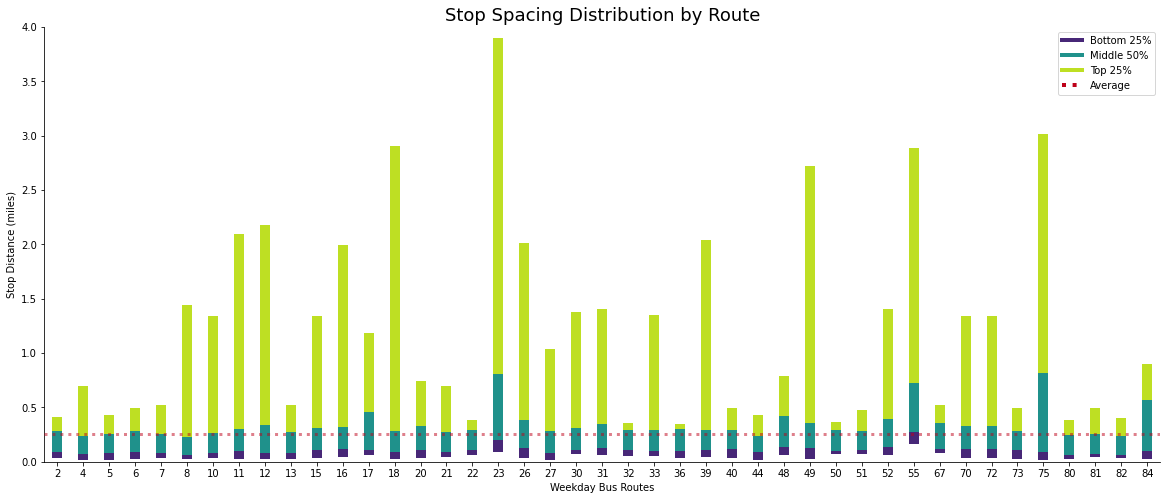

In [19]:
ax = plt.subplots(figsize=(20, 8))[1]
yscale = 4

for i, col in enumerate(weekday_routes_92_allTrips.columns):
    s = weekday_routes_92_allTrips[col]
    x = i+1
    
    #y = s.quantile(0.5)
    #ax.plot(x, y, color='#ff9408', linewidth=3, markersize=5, marker = "_", alpha=.9, zorder=4)

    y1 = s.quantile(0.75)/yscale
    y2 = s.quantile(1)/yscale
    #ax.plot((x, x), (y1, y2), color='#87ae73', linewidth=10, markersize=1, linestyle = "-", alpha=.9)
    ax.axvline(x, ymin=y1, ymax=y2, color='#bedf23', linewidth=10, markersize=1, linestyle = "-", alpha=1, zorder=1)
    
    y1 = s.quantile(0.25)/yscale
    y2 = s.quantile(0.75)/yscale
    ax.axvline(x, ymin=y1, ymax=y2, color='#1f918b', linewidth=10, markersize=1, linestyle = "-", alpha=1, zorder=2)
    #ax.plot((x, x), (y1, y2), color='#b00149', linewidth=10, markersize=1, linestyle = "-", alpha=.9)

    y1 = s.quantile(0)/yscale
    y2 = s.quantile(0.25)/yscale
    ax.axvline(x, ymin=y1, ymax=y2, color='#472777', linewidth=10, markersize=1, linestyle = "-", alpha=1, zorder=1)
    #ax.plot((x, x), (y1, y2), color='#34013f', linewidth=10, markersize=1, linestyle = "-", alpha=.9)

ax.axhline(y=0.2585, xmin=0, xmax=47, color="#be0119", alpha=.5, linestyle=":", lw=3, zorder=4)  

ax.set_xlim(0.5, len(weekday_routes_92_allTrips.columns)+0.5)
ax.set_ylim(0, yscale)
ax.set_xticklabels(list(weekday_routes_92_allTrips.columns))
ax.set_xticks(range(1, len(weekday_routes_92_allTrips.columns)+1))
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel("Weekday Bus Routes")
plt.ylabel("Stop Distance (miles)")

#plt.grid(axis='y', linestyle='--')

custom_lines = [Line2D([0], [0], color='#472777', lw=4), Line2D([0], [0], color='#1f918b', lw=4), Line2D([0], [0], color='#bedf23', lw=4), 
                Line2D([0], [0], color='#be0119', lw=4, linestyle=":")]
plt.legend(custom_lines, ['Bottom 25%', 'Middle 50%', 'Top 25%', 'Average'])

plt.title("Stop Spacing Distribution by Route", fontsize=18)
plt.savefig("PaperFigures/Quartiles_allTrips_Weekdays", bbox_inches='tight')

plt.show()

<ipython-input-22-f789b9eae064>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(weekday_routes_92_allTrips.columns))


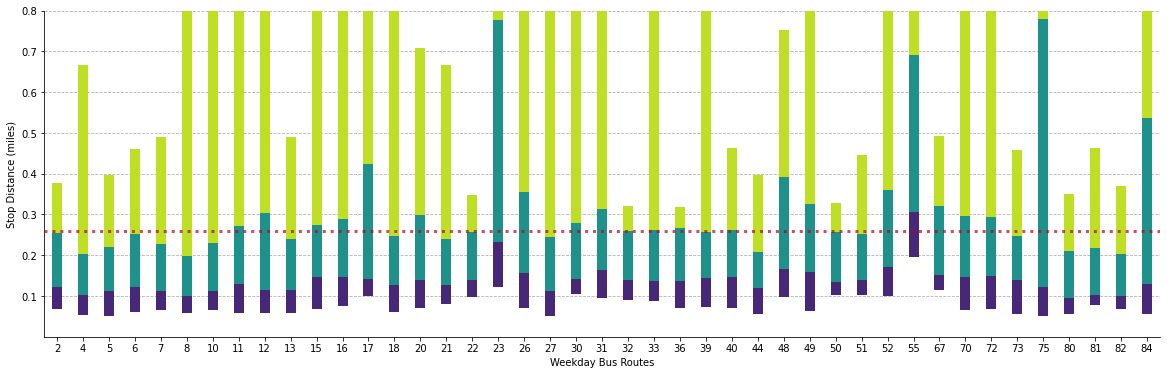

In [22]:
fig, ax = plt.subplots(figsize=(20, 6))
yscale = .8

for i, col in enumerate(weekday_routes_92_allTrips.columns):
    s = weekday_routes_92_allTrips[col]
    x = i+1

    y1 = s.quantile(0.75)/yscale
    y2 = s.quantile(1)/yscale
    #ax.plot((x, x), (y1, y2), color='#87ae73', linewidth=10, markersize=1, linestyle = "-", alpha=.9)
    ax.axvline(x, ymin=y1, ymax=y2, color='#bedf23', linewidth=10, markersize=1, linestyle = "-", alpha=1, zorder=2)
    
    y1 = s.quantile(0.25)/yscale
    y2 = s.quantile(0.75)/yscale
    ax.axvline(x, ymin=y1, ymax=y2, color='#1f918b', linewidth=10, markersize=1, linestyle = "-", alpha=1, zorder=3)
    #ax.plot((x, x), (y1, y2), color='#b00149', linewidth=10, markersize=1, linestyle = "-", alpha=.9)

    y1 = s.quantile(0)/yscale
    y2 = s.quantile(0.25)/yscale
    ax.axvline(x, ymin=y1, ymax=y2, color='#472777', linewidth=10, markersize=1, linestyle = "-", alpha=1, zorder=2)
    #ax.plot((x, x), (y1, y2), color='#34013f', linewidth=10, markersize=1, linestyle = "-", alpha=.9)
    
ax.axhline(y=0.2585, xmin=0, xmax=47, color="#be0119", alpha=.7, linestyle=":", lw=3, zorder=4)   

ax.set_xlim(0.5, len(weekday_routes_92_allTrips.columns)+0.5)
ax.set_ylim(0, yscale)
ax.set_xticklabels(list(weekday_routes_92_allTrips.columns))
ax.set_xticks(range(1, len(weekday_routes_92_allTrips.columns)+1))
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel("Weekday Bus Routes")
plt.ylabel("Stop Distance (miles)")

plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8])
plt.grid(axis='y', linestyle='--', zorder=0)

custom_lines = [Line2D([0], [0], color='#472777', lw=4), Line2D([0], [0], color='#1f918b', lw=4), Line2D([0], [0], color='#bedf23', lw=4), 
                Line2D([0], [0], color='#be0119', lw=4, linestyle=":")]
#plt.legend(custom_lines, ['Bottom 25%', 'Middle 50%', 'Top 25%', 'Average'])

#plt.title("Stop Spacing Distribution by Route", fontsize=18)
plt.savefig("PaperFigures/Quartiles_allTrips_Weekdays_zoom", bbox_inches='tight')

plt.show()